# Fundamentals of Machine Learning - 2022
## Report 1 - Classification task
Pablo Chehade  
Última modificación: 10/09/2022


### Introducción

El objetivo es construir un modelo de machine learning que sea capaz de predecir el target de un problema lo mejor posible.  
- TARGET: clase de árbol más frecuente en una celda de 30m por 30m que contiene distintos tipos de árboles
- PREDICTOR VARIABLES: info. geográfica sobre tal celda, como por ejemplo pendiente del suelo, distacia a cuerpos de agua o posibles fire sports, etc.  

Para tal fin se puede experimentar con solo dos modelos: random forests y xgboost  

- Plantear una descripción gral de los modelos que se pueden utilizar
- Dar una especie de orden en el cual se irán atacando los problemas

En primer lugar, se realizó un análisis exploratorio de los datos

In [47]:
#Importo librerías
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split #Para dividir el dataset en 2 partes


### Análisis Exploratorio de los Datos

#### Primer vistazo a los datos

In [48]:
#Importo el dataset con pandas
data = pd.read_csv('datasets/train_r1.csv')

In [49]:
#Imprimo las primeras columnas
data.head()

,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_area_silvestre,clase_suelo,dosel_forestal
0,2596,51,3,258,0,510,221,232,148,6279,1,29,5
1,2804,139,9,268,65,3180,234,238,135,6121,1,12,2
2,2785,155,18,242,118,3090,238,238,122,6211,1,30,2
3,2595,45,2,153,-1,391,220,234,150,6172,1,29,5
4,2579,132,6,300,-15,67,230,237,140,6031,1,29,2


In [50]:
#Imprimo info gral del dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464810 entries, 0 to 464809
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   altura                464810 non-null  int64
 1   exposicion            464810 non-null  int64
 2   inclinacion_suelo     464810 non-null  int64
 3   distancia_agua        464810 non-null  int64
 4   altura_agua           464810 non-null  int64
 5   distancia_caminos     464810 non-null  int64
 6   sombra_maniana        464810 non-null  int64
 7   sombra_mediodia       464810 non-null  int64
 8   sombra_tarde          464810 non-null  int64
 9   distancia_fuego       464810 non-null  int64
 10  clase_area_silvestre  464810 non-null  int64
 11  clase_suelo           464810 non-null  int64
 12  dosel_forestal        464810 non-null  int64
dtypes: int64(13)
memory usage: 46.1 MB


In [51]:
#data["clase_area_silvestre"].value_counts()
#data["clase_suelo"].value_counts()
data["dosel_forestal"].value_counts()

2    226596
1    169395
3     28602
7     16406
6     13993
5      7614
4      2204
Name: dosel_forestal, dtype: int64

##### Observaciones

Se tienen 12 variables predictoras y 1 target (clase_forestal). Tipos de variables:
- Las variables exposicion (columna 2) e inclinacion_suelo (columna 3) se encuentran en grados.
- Las variables sombra_maniana (columna 7), sombra_mediodia (columna 8) y sombra_tarde (columna 9) son enteros en el intervalo [0,255].
- Las variables clase_area_silvestre (columna 11), clase_suelo (columna 12) y dosel_forestal (columna 13) son categóricas. La primera tiene 4 categorías, la 2da, 40 y la 3ra, 7. Los nros enteros representan clases.  
- El resto de variables son distancias en metro  

Datos nulos: No hay datos nulos en el dataset.

#### Separo entre Train y Test

In [52]:
#Divido el dataset entre train y test. A partir de ahora no utilizaré test
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data, test_size=0.2, random_state=42) ### Fijamos 20% para test y 42 es el random state para poder reproducir los resultados.

#Guardo el test set en un archivo pickle
test_set.to_pickle("datasets/data_test.pkl")

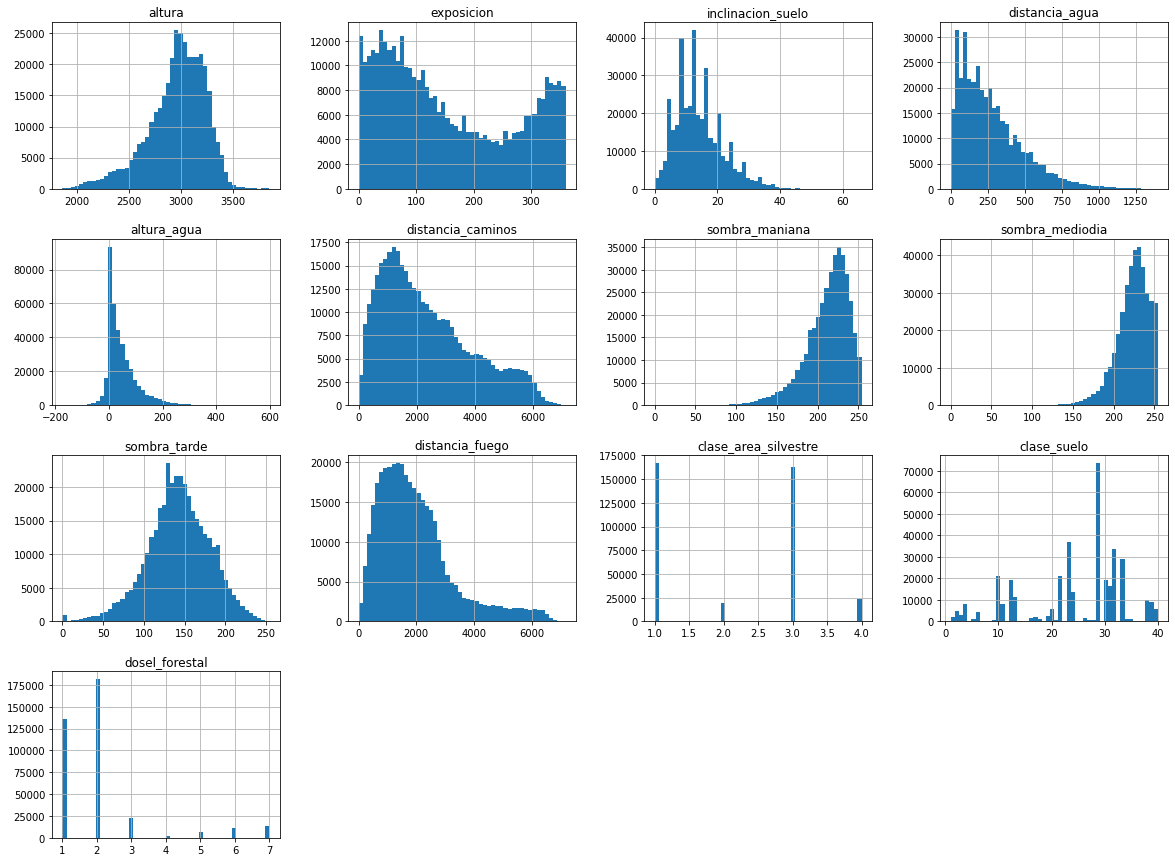

In [53]:
#Hago un histograma de cada atributo
train_set.hist(bins=50, figsize=(20,15));


In [54]:
#Analizo correlaciones entre atributos
corr_matrix = train_set.corr()
#plt.matshow(corr_matrix) #No aporta mucha info. la matriz de correlaciones

corr_matrix = train_set.corr()
print(corr_matrix["dosel_forestal"].sort_values(ascending=True))

altura                 -0.268298
clase_suelo            -0.163547
distancia_caminos      -0.152848
distancia_fuego        -0.108455
sombra_mediodia        -0.095722
sombra_tarde           -0.048833
sombra_maniana         -0.034310
distancia_agua         -0.021745
exposicion              0.017364
altura_agua             0.080170
inclinacion_suelo       0.147542
clase_area_silvestre    0.276400
dosel_forestal          1.000000
Name: dosel_forestal, dtype: float64


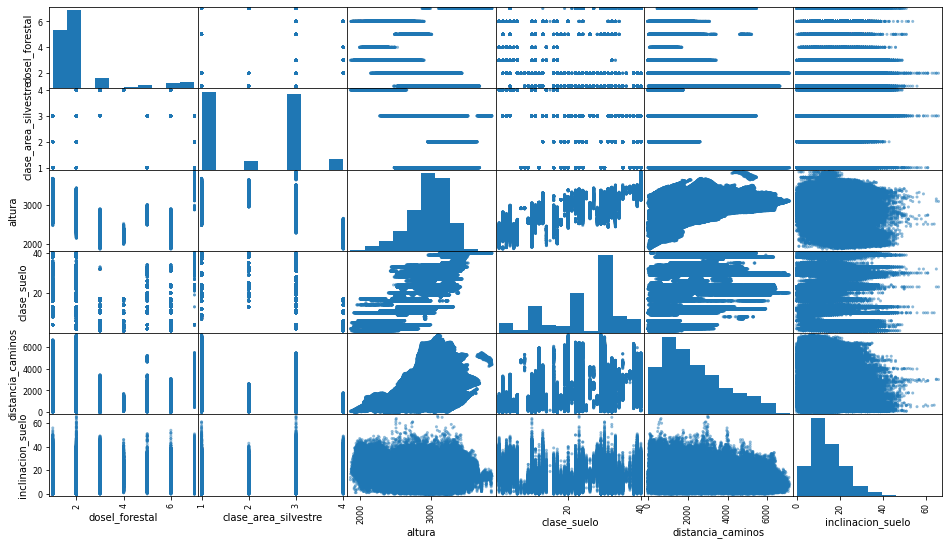

In [55]:
#Las correlaciones de mayor módulo son clase_area_silvestre, altura, clase_suelo, distancia_caminos e inclinacion_suelo.

feat_corr = ["dosel_forestal","clase_area_silvestre", "altura", "clase_suelo", "distancia_caminos"]
pd.plotting.scatter_matrix(train_set[feat_corr], figsize=(16, 9));

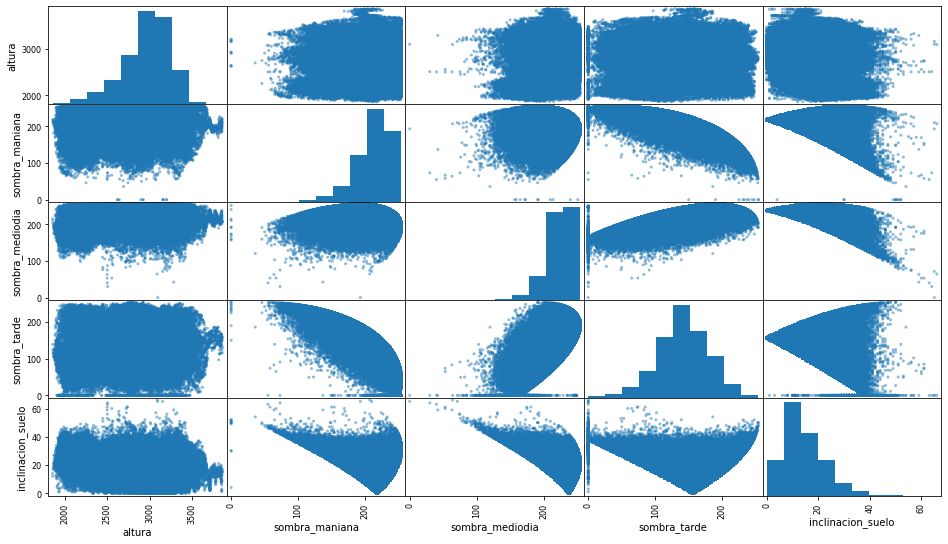

In [56]:
#Intuitivamente, también esperaría que las variables altura, las tres de sombra e inclinacion_suelo estén correlacionadas. Me fijo si realmente es así
feat_corr = ["altura", "sombra_maniana", "sombra_mediodia", "sombra_tarde", "inclinacion_suelo"]
pd.plotting.scatter_matrix(train_set[feat_corr], figsize=(16, 9));

##### Observaciones

- De los histogramas se obtiene que hay variables con distribución sesgada, tal como inclinacion_suelo, distancia_agua, entre otras. Pero tmb existen otras simétricas, como sombra_tarde. Por otro lado, no son de gran utilidad los histogramas de las variables categóricas, salvo para ver la proporción de datos para cada categoría. En el caso de la variable target dosel_forestal, la clase 2 está en mayor proporción que las demás. Mientras que la clase 4 es la de menor proporción.
- De la matriz de correlación se obtiene que
* Las comparaciones entre variables categóricas no son muy útiles. La única info. que se obtiene es que existen datos que pertenecen a una determinada categoría de una variable pero nunca pertenecen a una determinada categoría de otra variable. Por ej, parece no haber datos en la categoría 3 de dosel_forestal y categoría 2 de clase_area_silvestre. Quizás podríamos obtener mayor información si supiéramos qué significa cada categoría.
* Altura y clase_suelo parecen estar correlacionadas.
* Altura y distancia_caminos. Podríamos crear una nueva variable que sea el cociente entre la variable distancia_caminos y altura.
* Las variables de sombra tienen correlación entre sí, pero no se observa una clara correlación de las mismas con altura. Podría crear una variable que sea media de sombra_maniana, sombra_mediodia y sombra_tarde.

In [60]:
#Creo nuevas variables
sombra_mean = (train_set["sombra_maniana"] + train_set["sombra_mediodia"] + train_set["sombra_tarde"])/3
train_set["sombra_mean"] = sombra_mean

razon_distcaminos_altura = train_set["distancia_caminos"]/train_set["altura"]
train_set["razon_distcaminos_altura"] = razon_distcaminos_altura

#Analizo nuevamente las correlaciones
corr_matrix = train_set.corr()
print(corr_matrix["dosel_forestal"].sort_values(ascending=True))

altura                     -0.268298
clase_suelo                -0.163547
distancia_caminos          -0.152848
razon_distcaminos_altura   -0.142516
distancia_fuego            -0.108455
sombra_mean                -0.107742
sombra_mediodia            -0.095722
sombra_tarde               -0.048833
sombra_maniana             -0.034310
distancia_agua             -0.021745
exposicion                  0.017364
altura_agua                 0.080170
inclinacion_suelo           0.147542
clase_area_silvestre        0.276400
dosel_forestal              1.000000
Name: dosel_forestal, dtype: float64


##### Observaciones

La nueva variable sombra_mean tiene ligeramente mayor correlación que las variables sombra_maniana, sombra_mediodia y sombra_tarde por separado
La nueva variable razon_distcaminos_altura tiene menor correlación en módulo que distancia_caminos.

In [61]:
#Guardo los datos
train_set.to_pickle("datasets/data_train.pkl")

### Modelos

In [66]:
#Divido el train_set entre train_predictors y train_target
train_predictors = train_set.drop("dosel_forestal", axis=1)
train_target = train_set["dosel_forestal"].copy()



,altura,exposicion,inclinacion_suelo,distancia_agua,altura_agua,distancia_caminos,sombra_maniana,sombra_mediodia,sombra_tarde,distancia_fuego,clase_area_silvestre,clase_suelo,dosel_forestal,sombra_mean,razon_distcaminos_altura
357203,3064,358,6,30,0,3466,211,229,156,2882,3,23,1,198.666667,1.131201
123443,2857,9,5,446,53,2113,215,230,153,2108,1,29,2,199.333333,0.739587
397486,3163,287,22,892,388,1100,154,233,216,1480,3,33,1,201.000000,0.347771
24706,3096,154,25,234,49,5392,240,232,105,1635,1,29,2,192.333333,1.741602
176884,2045,318,28,272,50,330,135,202,200,192,4,5,3,179.000000,0.161369


#### Random Forest

Los árboles son robustos a la no normalización, por lo que no es necesario hacer standarización. Además, no hay missing values en los datos, por lo que no hay que trabajar con NaNs.

In [78]:
from sklearn.ensemble import RandomForestClassifier
#Creo el modelo
RFmodel = RandomForestClassifier(n_jobs = -1, random_state = 42)
#Lo entreno
RFmodel.fit(train_predictors, train_target)

RandomForestClassifier(n_jobs=-1)

##### Cross Validation

No me acuerdo qué era esto

##### Grid search

¿Qué atributos se pueden variar del RandomForest?  
- n_estimators: nro de trees en el forest  
Default: 100
Variación: entre 50 y 200  
- criterion: función para medir el error en el split
Default: "gini"
Variación: ninguna  
- max_depth: máxima depth en el tree
Default = None, es decir, los nodos se expanden hasta que todas las leaves sean puras  
Variación: None, 5 a 10
- min_samples_split: nro minimo de samples necesarios para hacer un split en un nodo interno
Default:
Variación: 
- min:samples_leaf: nro mínimo de samples necesario para estar en un leaf node.
Default:
Variación: 
- max_features: nro de atributos considerados al buscar el mejor split. Sea p la cantidad total de variables, por default se toma sqrt(p)
Default:
Variación:
- boostrap (bool): usar o no boostraped samples?
Default:
Variación: 
- oob_score (bool): usar o no out-of-bag samples para estimar el score de generalización?
Default:
Variación: 
- n_jobs: nro de jobs que se pueden hacer en paralelo. Por defecto tengo que poner -1 para que se usen todos los procesadores. Para dar una idea del orden de magnitud, la primera vez que hice el fit le tomó 1:41 s usando un procesador y 21 s usando todos los procesadores.
Default:
Variación:
- random_state: controla la aleatoriedad del boostraping de los samples. Es útil, entiendo, para poder tener reproducibilidad de los resultados
Default:
Variación:

In [79]:
from sklearn.model_selection import GridSearchCV
#parameters = {'n_jobs':('linear', 'rbf'), 'C':[1, 10]}
parameters = {'n_jobs':[1,-1]}
RFmodel = RandomForestClassifier()
clf = GridSearchCV(RFmodel, parameters)
clf.fit(train_predictors, train_target)
GridSearchCV(estimator=RFmodel(), param_grid=parameters)
sorted(clf.cv_results_.keys())

TypeError: predict() missing 1 required positional argument: 'X'

### Evalúo test

In [ ]:
#Calculo el error del modelo sobre el test set
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Para evaluar el test tengo que
#(1) Crear las nuevas variables
#(2) Dividir el test_set entre test_predictors y test_target
sombra_mean = (test_set["sombra_maniana"] + test_set["sombra_mediodia"] + test_set["sombra_tarde"])/3
test_set["sombra_mean"] = sombra_mean

razon_distcaminos_altura = test_set["distancia_caminos"]/test_set["altura"]
test_set["razon_distcaminos_altura"] = razon_distcaminos_altura

test_predictors = test_set.drop("dosel_forestal", axis=1)
test_target = test_set["dosel_forestal"].copy()

RFmodel_mse = (test_target,RFmodel.predict(test_predictors))
print("Mean Square Error: ", RFmodel_mse )

RFmodel_mae = mean_absolute_error(test_target,RFmodel.predict(test_predictors))
print("Mean Absolute Error: ", RFmodel_mae )



0.20065187926249436